In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc
import xgboost as xgb
from xgboost import XGBClassifier


# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer

import warnings
warnings.filterwarnings("ignore")

In [20]:
data = pd.read_csv('hk201819.csv')
data = data.dropna()
# print(data.describe())



x = data[['H1aA', 'H1aB', 'H1bA', 'H1bB', 'H1cA', 'H1cB',
          'H1dA', 'H1dB', 'H1eA', 'H1eB', 'H1fA', 'H1fB', 'H1gA', 'H1gB', 'H2a', 'H2b', 'H2c', 'H2d', 'H2e', 'H2f',
          'H2g', 'H2h', 'H2i', 'H2j']]
y = data[['sCPS']]

In [21]:
scaler = preprocessing.StandardScaler().fit(x)

x = scaler.transform(x)

fa = FactorAnalyzer(rotation='varimax', n_factors=4, method='principal')
fa.fit(x)
x = fa.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2023, train_size=0.8)

K-Nearest Neighbors Algorithm with GridSearchCV

In [22]:
model_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid={'n_neighbors': range(2, 50)}, cv=10).fit(x_train, y_train)
print(model_knn.best_params_)
print('KNN, Training set score:', round(model_knn.score(x_train, y_train) * 100, 4))
print('KNN, Test set score:', round(model_knn.score(x_test, y_test) * 100, 4))

{'n_neighbors': 49}
KNN, Training set score: 63.7089
KNN, Test set score: 63.552


Random Forest Classifier with HyperOpt

In [23]:
def hyperopt_rf_score(params):
    clf = RandomForestClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_rf = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(2,400)),
    'max_features': hp.choice('max_features', range(2,10))
}

best = fmin(fn=hyperopt_rf_score, space=space_rf, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

nan                                                                             
{'criterion': 'entropy', 'max_depth': 276, 'max_features': 6}                   
nan                                                                             
{'criterion': 'entropy', 'max_depth': 51, 'max_features': 9}                    
nan                                                                             
{'criterion': 'gini', 'max_depth': 285, 'max_features': 9}                      
nan                                                                             
{'criterion': 'gini', 'max_depth': 296, 'max_features': 5}                      
nan                                                                             
{'criterion': 'entropy', 'max_depth': 140, 'max_features': 7}                   
0.6295373857611318                                                              
{'criterion': 'gini', 'max_depth': 10, 'max_features': 3}                       
nan                         

In [24]:
params = space_eval(space_rf, best)
params

{'criterion': 'gini', 'max_depth': 10, 'max_features': 3}

In [25]:
model_random_forest = RandomForestClassifier(**params)
model_random_forest.fit(x_train, y_train)
model_random_forest.score(x_train, y_train)
print('Random Forest Classifier, Training set score:', round(model_random_forest.score(x_train, y_train) * 100, 4))
print('Random Forest Classifier, Test set score:', round(model_random_forest.score(x_test, y_test) * 100, 4))

Random Forest Classifier, Training set score: 68.7355
Random Forest Classifier, Test set score: 63.961


AdaBoost Classifier

In [26]:
def hyperopt_ab_score(params):
    clf = AdaBoostClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_ab = {
    'n_estimators': hp.choice('n_estimators', range(50, 1000)),
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001)
}

best = fmin(fn=hyperopt_ab_score, space=space_ab, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.5077723424602734                                                              
{'learning_rate': 0.0441, 'n_estimators': 823}                                  
0.5923309942320181                                                              
{'learning_rate': 0.0342, 'n_estimators': 517}                                  
0.584267823955116                                                               
{'learning_rate': 0.0409, 'n_estimators': 315}                                  
0.5855261492881061                                                              
{'learning_rate': 0.0189, 'n_estimators': 660}                                  
0.4940855367923486                                                              
{'learning_rate': 0.0458, 'n_estimators': 817}                                  
0.581317561390194                                                               
{'learning_rate': 0.0285, 'n_estimators': 121}                                  
0.5834022863397864          

In [27]:
params = space_eval(space_ab, best)
params

{'learning_rate': 0.0458, 'n_estimators': 817}

In [28]:
model_ada_boost = AdaBoostClassifier(**params)
model_ada_boost.fit(x_train, y_train)
print('AdaBoost Classifier, Training set score:', round(model_ada_boost.score(x_train, y_train) * 100, 4))
print('AdaBoost Classifier, Test set score:', round(model_ada_boost.score(x_test, y_test) * 100, 4))

AdaBoost Classifier, Training set score: 51.5752
AdaBoost Classifier, Test set score: 52.1158


XGB Classifier with HyperOpt

In [29]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_xgb = {
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
    'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'exact'
}

best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6274922783667728                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.905, 'eta': 0.215, 'eval_metric': 'auc', 'gamma': 0.92, 'learning_rate': 0.024200000000000003, 'max_depth': 11, 'min_child_weight': 2.3000000000000003, 'n_estimators': 194, 'objective': 'binary:logistic', 'subsample': 0.6950000000000001, 'tree_method': 'exact'}
0.6233232616154                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.625, 'eta': 0.265, 'eval_metric': 'auc', 'gamma': 0.85, 'learning_rate': 0.0414, 'max_depth': 8, 'min_child_weight': 3.95, 'n_estimators': 320, 'objective': 'binary:logistic', 'subsample': 0.85, 'tree_method': 'exact'}
0.62383493293789                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.74, 'eta': 0.22, 'eval_metric': 'auc', 'gamma': 0.715, 'learning_rate': 0.0354, 'max_depth': 4, 'min_child_weight': 4.125, 'n_estimators': 103, 

In [30]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.7000000000000001,
 'eta': 0.17500000000000002,
 'eval_metric': 'auc',
 'gamma': 0.8150000000000001,
 'learning_rate': 0.005200000000000001,
 'max_depth': 3,
 'min_child_weight': 6.25,
 'n_estimators': 348,
 'objective': 'binary:logistic',
 'subsample': 0.62,
 'tree_method': 'exact'}

In [31]:
model_xgb = XGBClassifier(**params)
model_xgb.fit(x_train, y_train)
print('XGB Classifier, Training set score:', round(model_xgb.score(x_train, y_train) * 100, 4))
print('XGB Classifier, Test set score:', round(model_xgb.score(x_test, y_test) * 100, 4))

XGB Classifier, Training set score: 61.9076
XGB Classifier, Test set score: 63.0958


ROC Curve

In [32]:
def multi_models_roc(names, sampling_methods, colors, x_test, y_test, save=False, dpin=300):

        plt.figure(figsize=(10, 10), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            
            y_test_preds = method.predict(x_test)
            y_test_predprob = method.predict_proba(x_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)

            plt.plot(fpr, tpr, lw=2, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=20)
            plt.ylabel('True Positive Rate',fontsize=20)
            plt.title('ROC Curve',fontsize=25)
            plt.legend(loc='lower right',fontsize =16.6)

        if save:
            plt.savefig('multi_models_roc.png')

        return plt

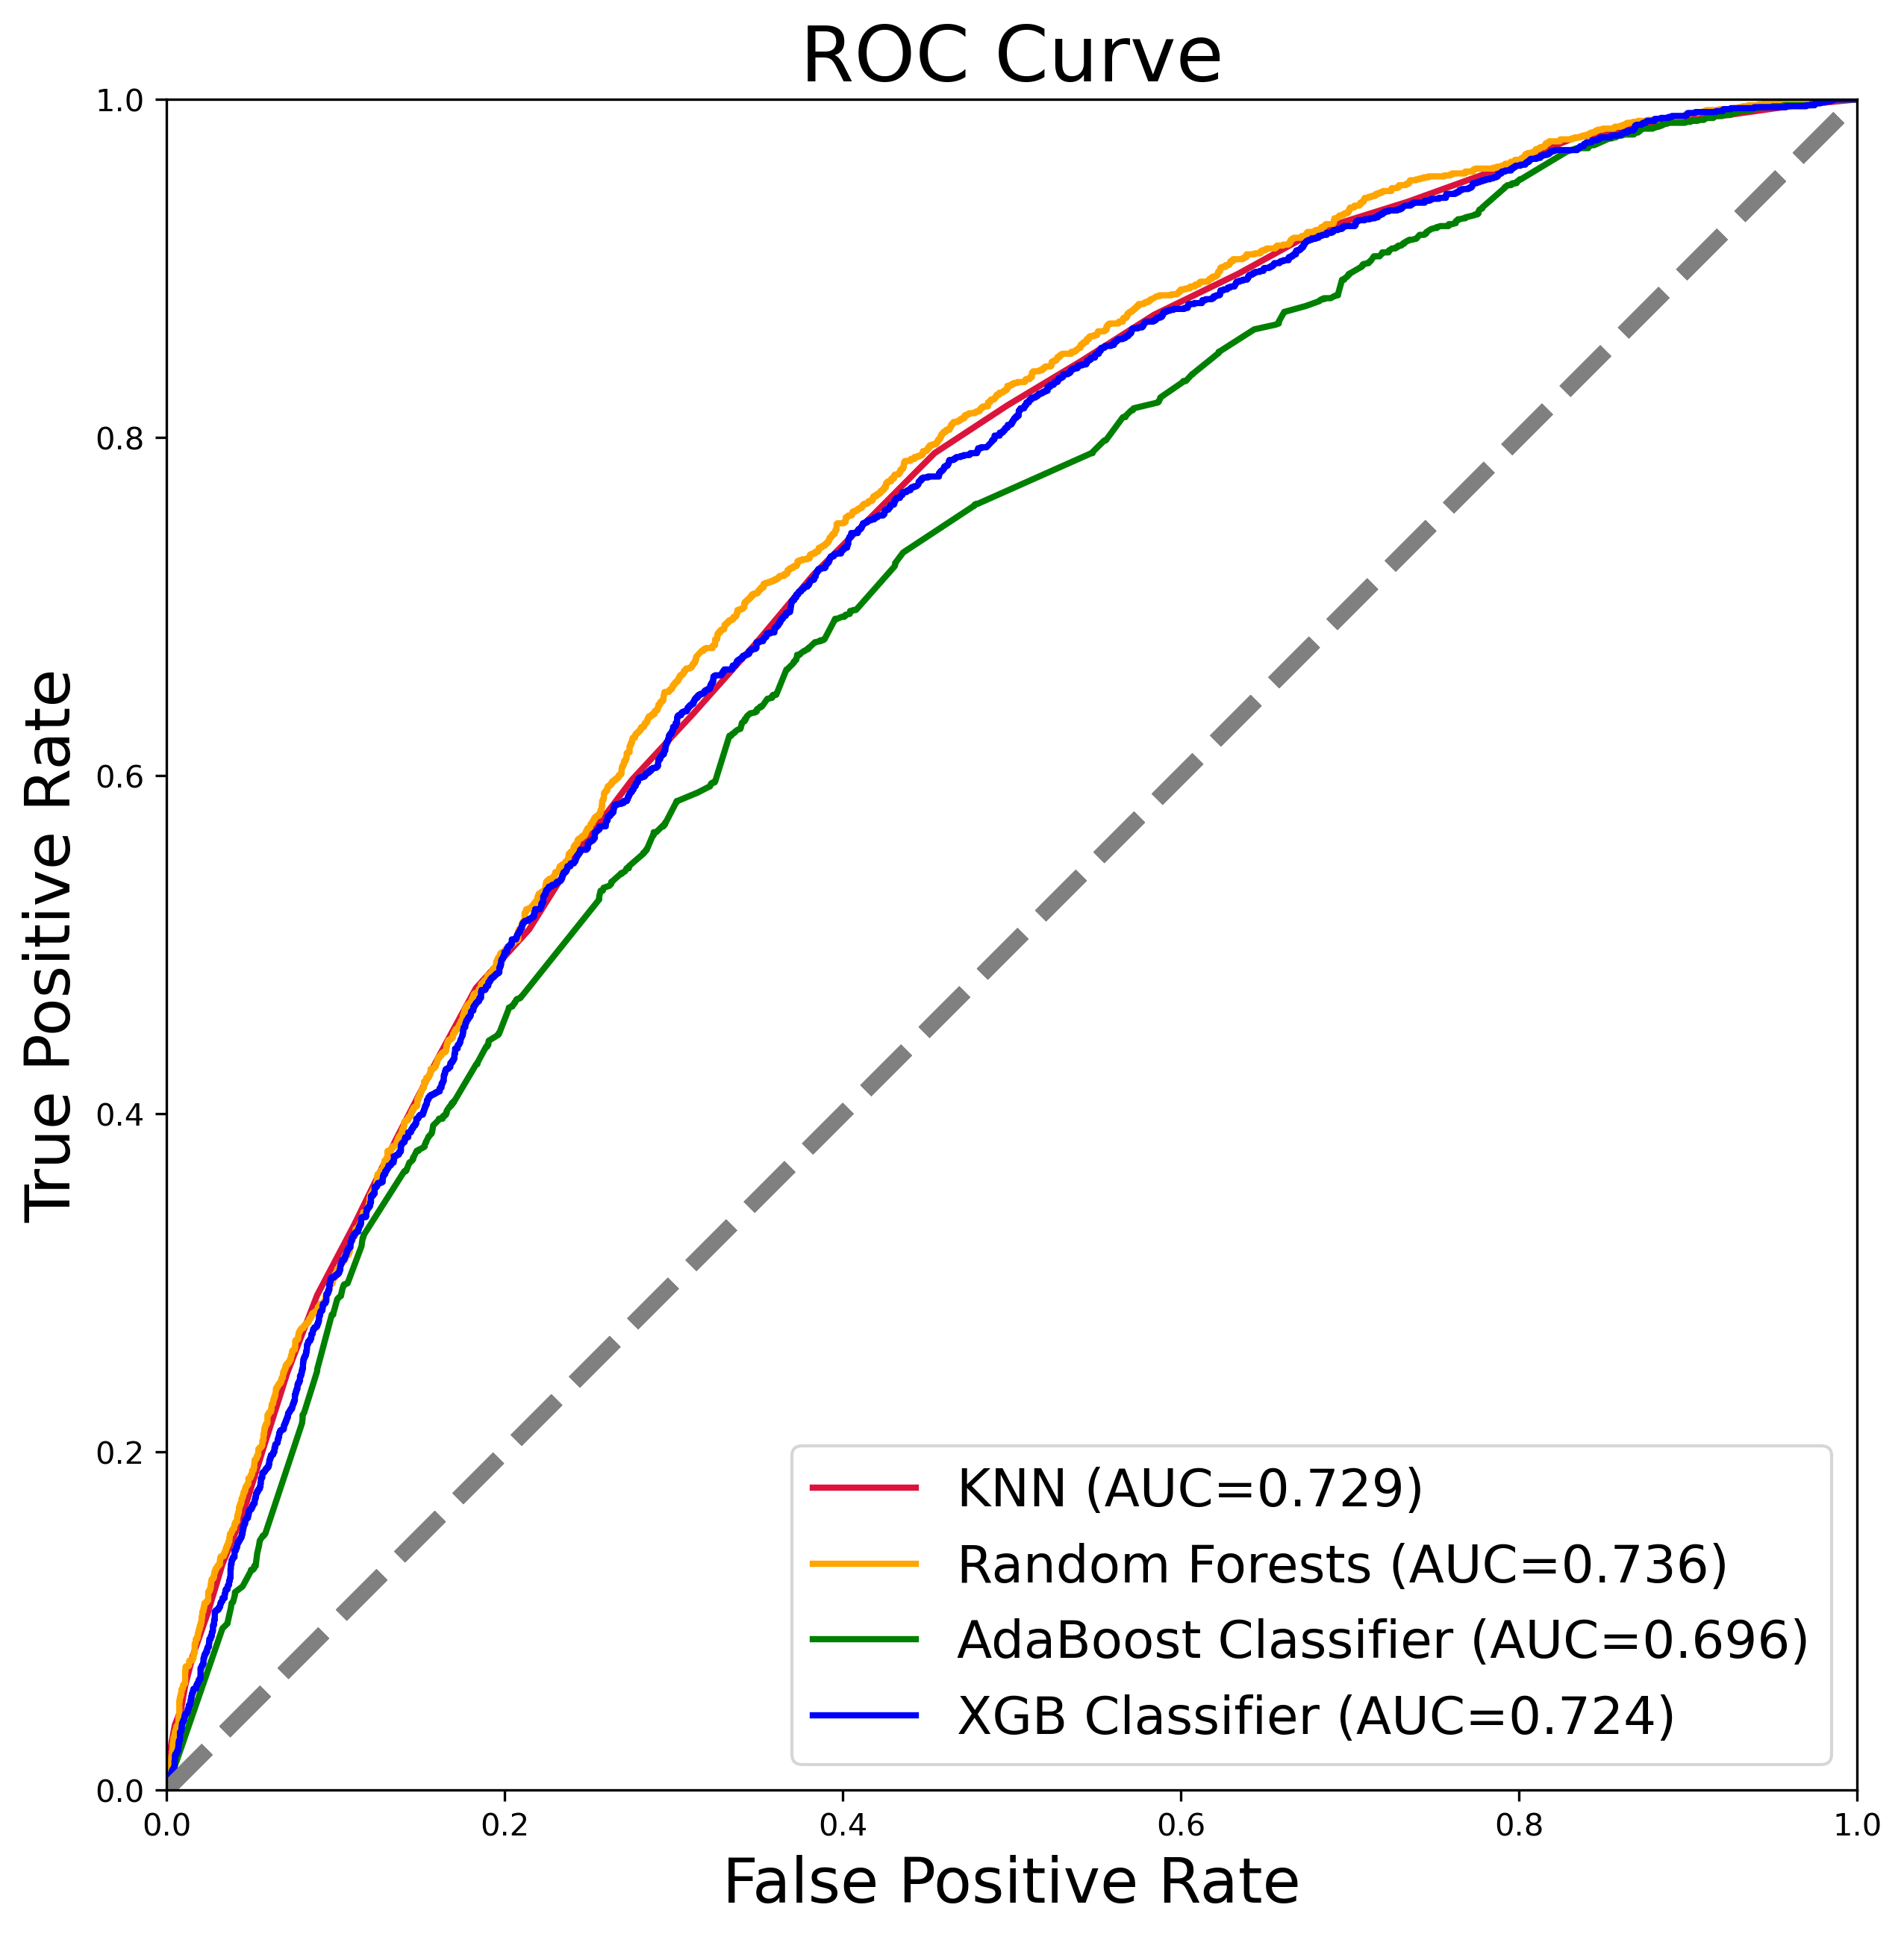

In [33]:
names = ['KNN','Random Forests','AdaBoost Classifier', 'XGB Classifier']

sampling_methods = [model_knn, model_random_forest, model_ada_boost, model_xgb]

colors = ['crimson', 'orange','green','blue', 'plum']

#ROC curves
test_roc_graph = multi_models_roc(names, sampling_methods, colors, x_test, y_test)

factors = 3

In [37]:
data = pd.read_csv('hk201819.csv')
data = data.dropna()
# print(data.describe())



x = data[['H1aA', 'H1aB', 'H1bA', 'H1bB', 'H1cA', 'H1cB',
          'H1dA', 'H1dB', 'H1eA', 'H1eB', 'H1fA', 'H1fB', 'H1gA', 'H1gB', 'H2a', 'H2b', 'H2c', 'H2d', 'H2e', 'H2f',
          'H2g', 'H2h', 'H2i', 'H2j']]
y = data[['sCPS']]

In [38]:
scaler = preprocessing.StandardScaler().fit(x)

x = scaler.transform(x)

fa = FactorAnalyzer(rotation='varimax', n_factors=3, method='principal')
fa.fit(x)
x = fa.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2023, train_size=0.8)

K-Nearest Neighbors Algorithm with GridSearchCV

In [39]:
model_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid={'n_neighbors': range(2, 50)}, cv=10).fit(x_train, y_train)
print(model_knn.best_params_)
print('KNN, Training set score:', round(model_knn.score(x_train, y_train) * 100, 4))
print('KNN, Test set score:', round(model_knn.score(x_test, y_test) * 100, 4))

{'n_neighbors': 47}
KNN, Training set score: 63.2291
KNN, Test set score: 62.4351


Random Forest Classifier with HyperOpt

In [40]:
def hyperopt_rf_score(params):
    clf = RandomForestClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_rf = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(2,400)),
    'max_features': hp.choice('max_features', range(2,10))
}

best = fmin(fn=hyperopt_rf_score, space=space_rf, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

nan                                                                             
{'criterion': 'entropy', 'max_depth': 147, 'max_features': 8}                   
0.5948865199141253                                                              
{'criterion': 'gini', 'max_depth': 155, 'max_features': 2}                      
nan                                                                             
{'criterion': 'gini', 'max_depth': 246, 'max_features': 4}                      
nan                                                                             
{'criterion': 'entropy', 'max_depth': 367, 'max_features': 4}                   
0.5957909480151465                                                              
{'criterion': 'entropy', 'max_depth': 339, 'max_features': 2}                   
nan                                                                             
{'criterion': 'entropy', 'max_depth': 135, 'max_features': 8}                   
0.5952008924082492          

In [41]:
params = space_eval(space_rf, best)
params

{'criterion': 'gini', 'max_depth': 155, 'max_features': 2}

In [42]:
model_random_forest = RandomForestClassifier(**params)
model_random_forest.fit(x_train, y_train)
model_random_forest.score(x_train, y_train)
print('Random Forest Classifier, Training set score:', round(model_random_forest.score(x_train, y_train) * 100, 4))
print('Random Forest Classifier, Test set score:', round(model_random_forest.score(x_test, y_test) * 100, 4))

Random Forest Classifier, Training set score: 96.8614
Random Forest Classifier, Test set score: 60.4845


AdaBoost Classifier

In [43]:
def hyperopt_ab_score(params):
    clf = AdaBoostClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_ab = {
    'n_estimators': hp.choice('n_estimators', range(50, 1000)),
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001)
}

best = fmin(fn=hyperopt_ab_score, space=space_ab, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.5805308102679545                                                              
{'learning_rate': 0.019200000000000002, 'n_estimators': 187}                    
0.46533545905778595                                                             
{'learning_rate': 0.046, 'n_estimators': 903}                                   
0.48358609570772176                                                             
{'learning_rate': 0.031400000000000004, 'n_estimators': 901}                    
0.4921213352214453                                                              
{'learning_rate': 0.026500000000000003, 'n_estimators': 910}                    
0.578839723862082                                                               
{'learning_rate': 0.0011, 'n_estimators': 655}                                  
0.5754975708142529                                                              
{'learning_rate': 0.0264, 'n_estimators': 381}                                  
0.578839723862082           

In [44]:
params = space_eval(space_ab, best)
params

{'learning_rate': 0.046, 'n_estimators': 903}

In [45]:
model_ada_boost = AdaBoostClassifier(**params)
model_ada_boost.fit(x_train, y_train)
print('AdaBoost Classifier, Training set score:', round(model_ada_boost.score(x_train, y_train) * 100, 4))
print('AdaBoost Classifier, Test set score:', round(model_ada_boost.score(x_test, y_test) * 100, 4))

AdaBoost Classifier, Training set score: 50.0924
AdaBoost Classifier, Test set score: 49.8978


XGB Classifier with HyperOpt

In [46]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_xgb = {
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
    'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'exact'
}

best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6222611986499401                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.785, 'eta': 0.04, 'eval_metric': 'auc', 'gamma': 0.895, 'learning_rate': 0.0128, 'max_depth': 10, 'min_child_weight': 5.9750000000000005, 'n_estimators': 188, 'objective': 'binary:logistic', 'subsample': 0.75, 'tree_method': 'exact'}
0.6192332015223289                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.77, 'eta': 0.385, 'eval_metric': 'auc', 'gamma': 0.985, 'learning_rate': 0.0014, 'max_depth': 5, 'min_child_weight': 1.2750000000000001, 'n_estimators': 284, 'objective': 'binary:logistic', 'subsample': 0.505, 'tree_method': 'exact'}
0.6229693798529958                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.835, 'eta': 0.225, 'eval_metric': 'auc', 'gamma': 0.525, 'learning_rate': 0.0146, 'max_depth': 4, 'min_child_weight': 8.625, 'n_estimators': 641, 'objective'

In [47]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.68,
 'eta': 0.27,
 'eval_metric': 'auc',
 'gamma': 0.765,
 'learning_rate': 0.0408,
 'max_depth': 11,
 'min_child_weight': 5.175000000000001,
 'n_estimators': 822,
 'objective': 'binary:logistic',
 'subsample': 0.54,
 'tree_method': 'exact'}

In [48]:
model_xgb = XGBClassifier(**params)
model_xgb.fit(x_train, y_train)
print('XGB Classifier, Training set score:', round(model_xgb.score(x_train, y_train) * 100, 4))
print('XGB Classifier, Test set score:', round(model_xgb.score(x_test, y_test) * 100, 4))

XGB Classifier, Training set score: 80.2675
XGB Classifier, Test set score: 61.3182


ROC Curve

In [49]:
def multi_models_roc(names, sampling_methods, colors, x_test, y_test, save=False, dpin=300):

        plt.figure(figsize=(10, 10), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            
            y_test_preds = method.predict(x_test)
            y_test_predprob = method.predict_proba(x_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)

            plt.plot(fpr, tpr, lw=2, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=20)
            plt.ylabel('True Positive Rate',fontsize=20)
            plt.title('ROC Curve',fontsize=25)
            plt.legend(loc='lower right',fontsize =16.6)

        if save:
            plt.savefig('multi_models_roc.png')

        return plt

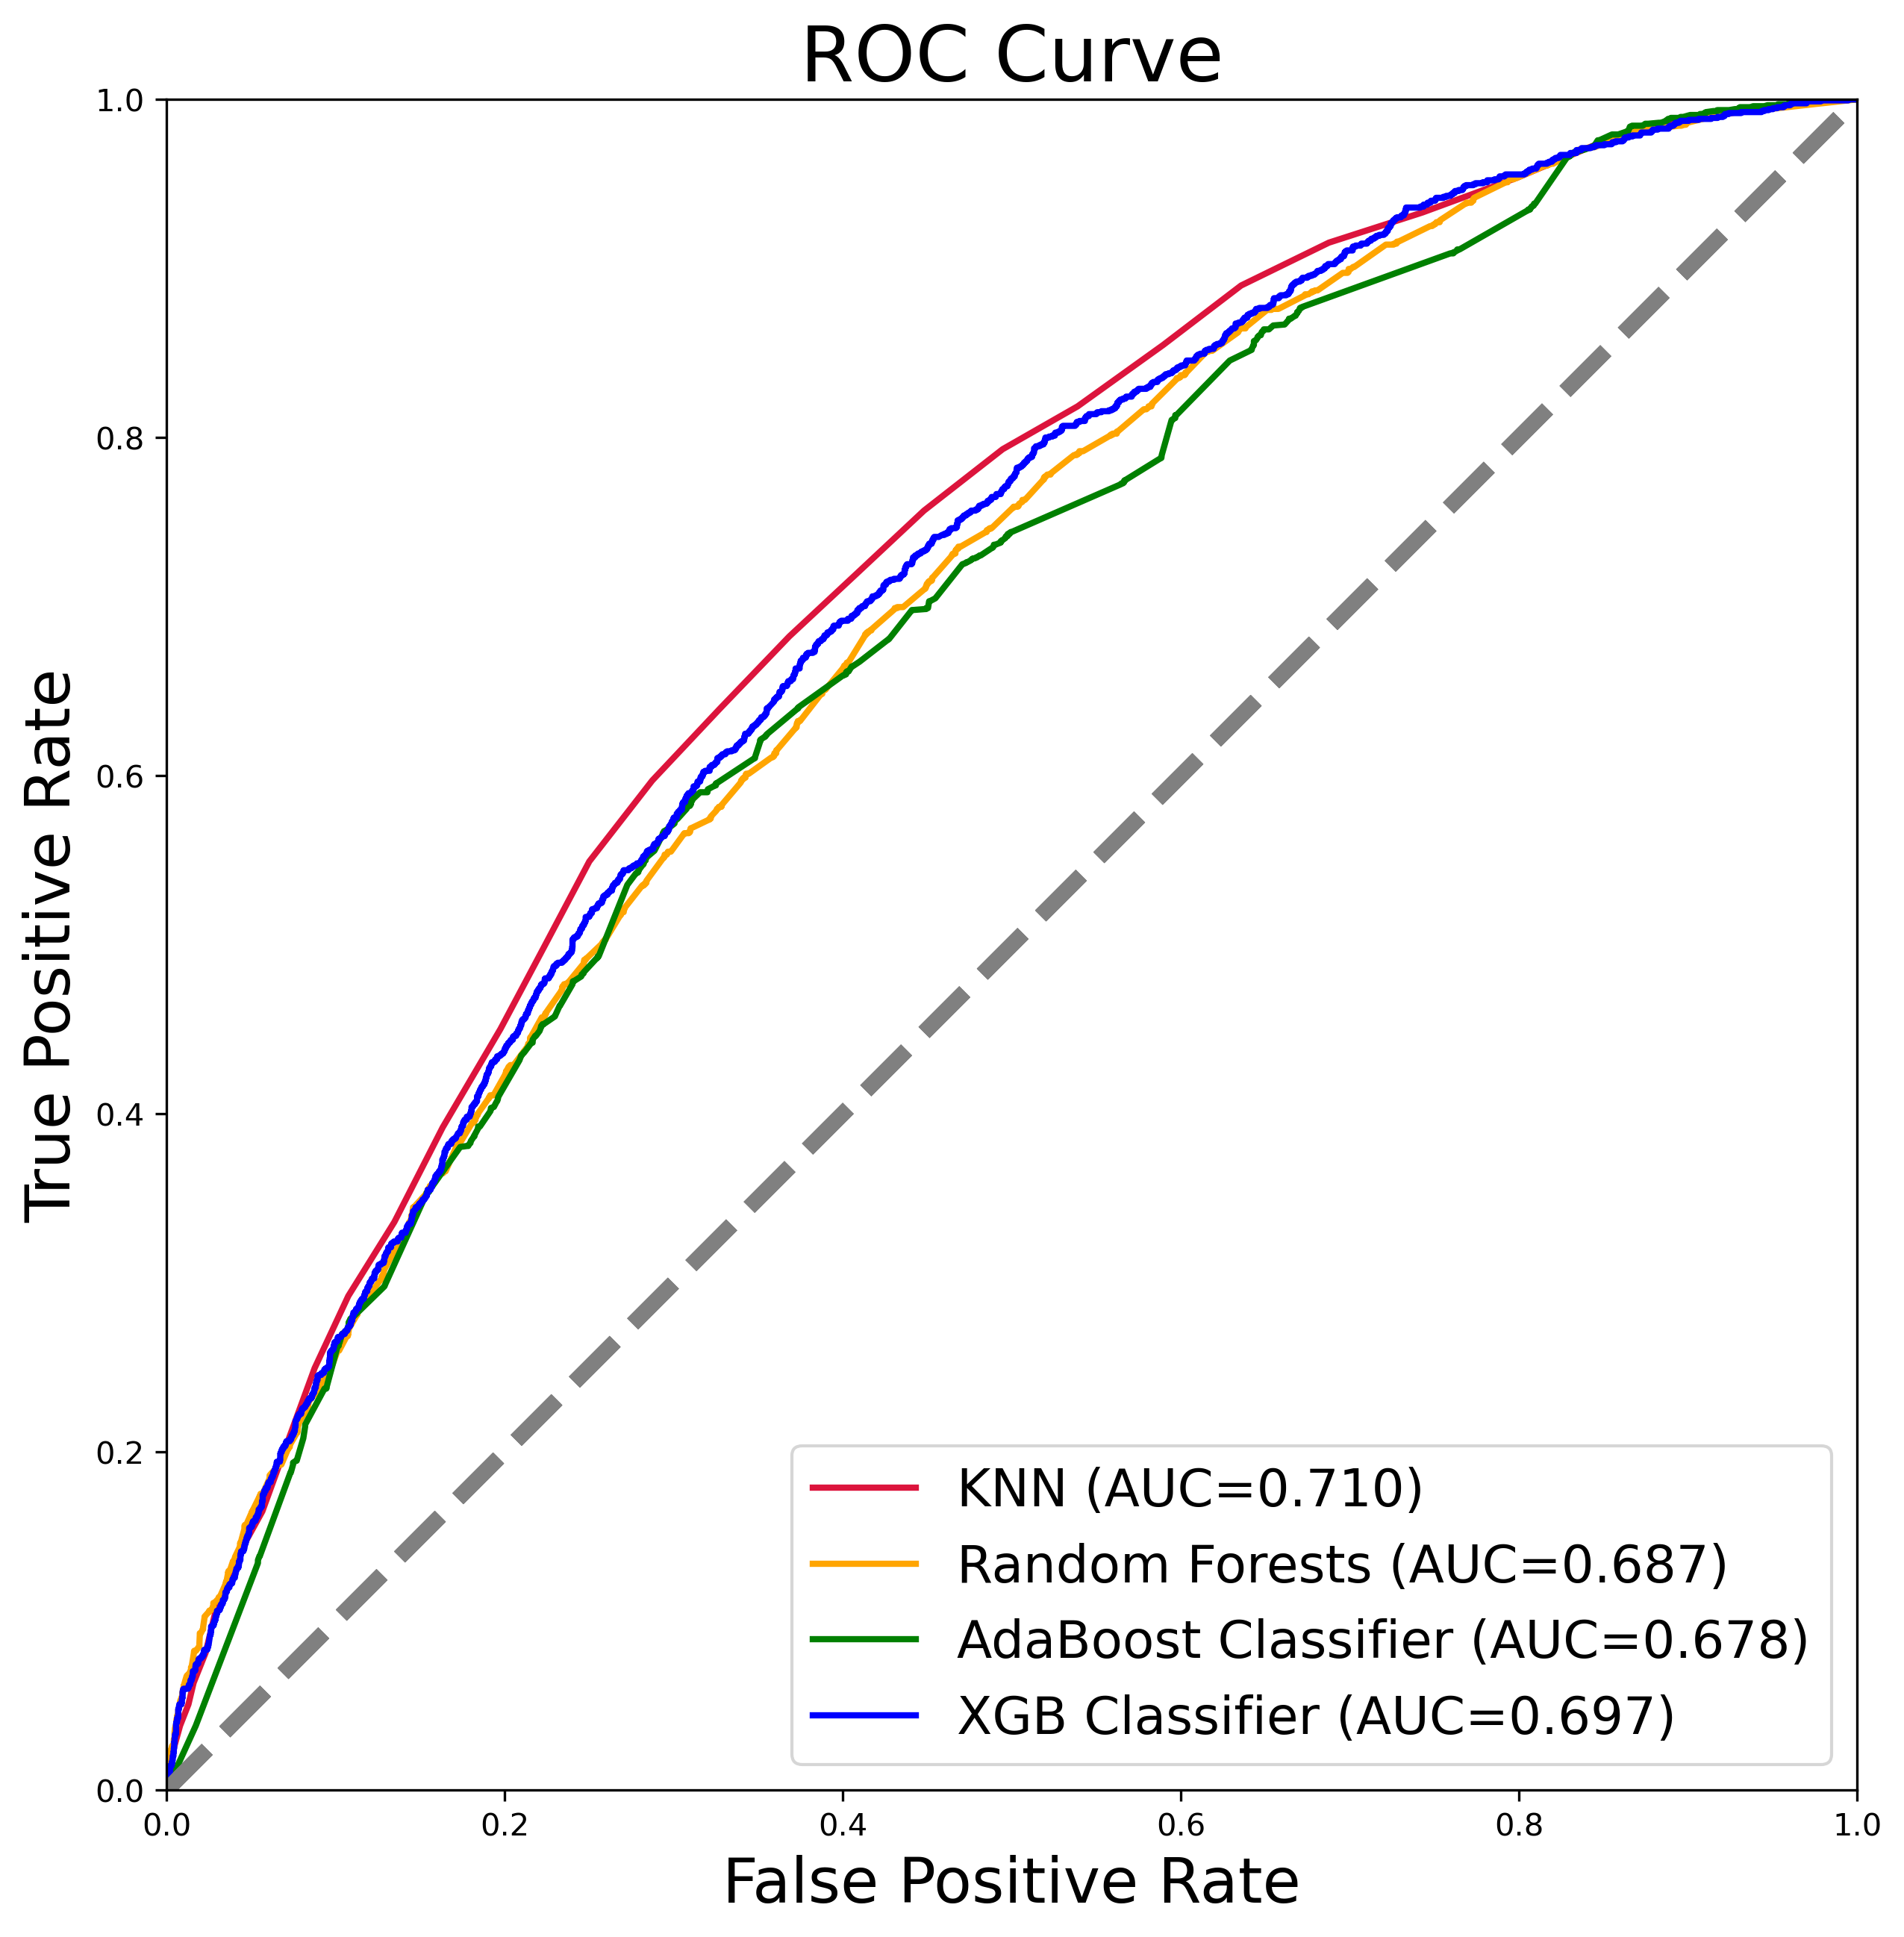

In [50]:
names = ['KNN','Random Forests','AdaBoost Classifier', 'XGB Classifier']

sampling_methods = [model_knn, model_random_forest, model_ada_boost, model_xgb]

colors = ['crimson', 'orange','green','blue', 'plum']

#ROC curves
test_roc_graph = multi_models_roc(names, sampling_methods, colors, x_test, y_test)